In [0]:
from __future__ import print_function
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       #transforms.RandomErasing(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [0]:
def norm2d(output_channels, batch_type = 'BN'):
  #print ("output channels: {}".format(output_channels))
  if batch_type == "GBN":
    num_splits = 2
    return GhostBatchNorm(output_channels, num_splits)
  else:
    return BatchNorm(output_channels)

In [0]:
class Net(nn.Module):
    def __init__(self, batch_type = "BN"):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 12, kernel_size=3, padding=0), # RF 3
            # BatchNorm2d(12),
            norm2d(12, batch_type),           
            ReLU(inplace=True),
            nn.Dropout(0.05),            

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 5
            # BatchNorm2d(12), 
            norm2d(12, batch_type),            
            ReLU(inplace=True),
            nn.Dropout(0.05),            

            Conv2d(12, 16, kernel_size=3, padding=0), # RF 7
            # BatchNorm2d(16), 
            norm2d(16, batch_type),            
            ReLU(inplace=True),
            nn.Dropout(0.05),                  

            MaxPool2d(kernel_size=2), # RF 8
            
            # Conv2d(16, 14, kernel_size=1, padding=0),
            # BatchNorm2d(14), 
            # norm2d(14, batch_type),            
            # ReLU(inplace=True),
            # nn.Dropout(0.1),            

            Conv2d(16, 12, kernel_size=1, padding=0), # RF 12
            # BatchNorm2d(12),
            norm2d(12, batch_type),             
            ReLU(inplace=True),
            nn.Dropout(0.05),            
            
            Conv2d(12, 12, kernel_size=3, padding=0), # RF 16
            # BatchNorm2d(12),
            norm2d(12, batch_type),             
            ReLU(inplace=True),
            nn.Dropout(0.05),

            Conv2d(12, 16, kernel_size=3, padding=0), # RF 20
            # BatchNorm2d(16),
            norm2d(16, batch_type),             
            ReLU(inplace=True),
            nn.Dropout(0.05),            

            Conv2d(16, 12, kernel_size=3, padding=0), # RF 24
            # BatchNorm2d(12),
            norm2d(12, batch_type),             
            ReLU(inplace=True),
            nn.Dropout(0.05),

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 24
            # BatchNorm2d(12),
            norm2d(12, batch_type),             
            ReLU(inplace=True),
            #nn.Dropout(0.05),

            nn.AdaptiveAvgPool2d((1,1)), # RF 28
            Conv2d(12, 10, kernel_size=1, bias = False) # RF 28

        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [11]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(batch_type = "GBN").to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
    GhostBatchNorm-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
    GhostBatchNorm-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,744
   GhostBatchNorm-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
def L1_reg(model, factor):
  reg_loss = 0
  for param in model.parameters():
    if param.dim() > 1:
      reg_loss += param.norm(1)
  loss = factor * reg_loss

  return loss

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc, lambda1=0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # # if L1 reg
    # if l1:
    loss += L1_reg(model, lambda1)
    
    loss_np = loss.cpu().data.numpy().item()
    train_losses.append(loss_np)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  return train_losses, train_acc


def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    flg = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Getting the misclassified Images and their labels

            tgt = target.view_as(pred)
            comp_df= pred.eq(tgt)
            mis_c = ~comp_df
            if flg == 0:
                misclassified_images = data[mis_c]
                misclassified_target = tgt[mis_c]
                misclassified_pred = pred[mis_c]
                flg =1
            else:  
                misclassified_images = torch.cat((data[mis_c],misclassified_images))
                misclassified_target = torch.cat((tgt[mis_c],misclassified_target))
                misclassified_pred = torch.cat((pred[mis_c],misclassified_pred))             

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, misclassified_images, misclassified_target, misclassified_pred

In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#model =  Net().to(device)
# combinations stores the list of possible regularization scenarios as tuples with first element of each tuple for L1 and second element for L2
l1_reg = 0.0005
l2_reg = 0.0005
combinations = [(0.0, 0.0, "BN"), (l1_reg, 0.0, "BN"), (0.0, l2_reg, "BN"), (l1_reg, l2_reg, "BN"), 
                (0.0, 0.0, "GBN"), (l1_reg, 0.0, "GBN"), (0.0, l2_reg, "GBN"), (l1_reg, l2_reg, "GBN")]
EPOCHS = 25

# We will store all the losses and accuracies (of different model runs) in the below dicts
complete_losses_test = {}
complete_acc_test = {}

# We will use below function to define which combination is being used
def comb_name(i):
        switcher={
                0:'BN Without L1 & L2 Regularization',
                1:'BN With L1 Regularization',
                2:'BN With L2 Regularization',
                3:'BN With L1 & L2 Regularization',
                4:'GBN Without L1 & L2 Regularization',
                5:'GBN With L1 Regularization',
                6:'GBN With L2 Regularization',
                7:'GBN With L1 & L2 Regularization'
             }

        return switcher.get(i)

j = 0
for i in combinations:
  l1_reg = i[0]
  l2_reg = i[1]
  batch_type = i[2]
  name = comb_name(j)
  j = j+1
  print ('\n\n', name, '\n')
  
  model = Net(batch_type = batch_type).to(device)

  test_acc = []
  test_losses = []
  train_losses = []
  train_acc = []

  # In Pytorch, L2 Regularization is added by using the weight_decay arguement in the optimizer class
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay= l2_reg)
  scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      # Value of l1_reg is passed tp train function to be added to the training loss function
      train(model, device, train_loader, optimizer, epoch, train_losses, train_acc, l1_reg)
      scheduler.step()
      loss, acc, misclassified_images1, misclassified_target1, misclassified_pred1 = test(model, device, test_loader, test_losses, test_acc)
      complete_losses_test[name] = loss
      complete_acc_test[name] = acc
      if (j==1):
        misclassified_images_bn, misclassified_target_bn, misclassified_pred_bn = misclassified_images1, misclassified_target1, misclassified_pred1 
      elif (j==5):
        misclassified_images_gbn, misclassified_target_gbn, misclassified_pred_gbn = misclassified_images1, misclassified_target1, misclassified_pred1     

  0%|          | 0/469 [00:00<?, ?it/s]



 BN Without L1 & L2 Regularization 

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.07174014300107956 Batch_id=468 Accuracy=84.09: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0714, Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.08797705918550491 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.14716564118862152 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.05584708973765373 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:13<00:00, 35.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.10399720817804337 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.1264047920703888 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.032995179295539856 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.05044366419315338 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.09850549697875977 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.05357775464653969 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.02890264429152012 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.09605389833450317 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.032100141048431396 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.01605214923620224 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.007169524673372507 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 35.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.019939212128520012 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9947/10000 (99.47%)

EPOCH: 16


Loss=0.06245282292366028 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.042139992117881775 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.014185820706188679 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.052848998457193375 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


Loss=0.03861670568585396 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


Loss=0.03720968961715698 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 36.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

EPOCH: 22


Loss=0.007745628710836172 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.010160733945667744 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.10972992330789566 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)



 BN With L1 Regularization 

EPOCH: 0


Loss=0.3346922695636749 Batch_id=468 Accuracy=85.70: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1228, Accuracy: 9666/10000 (96.66%)

EPOCH: 1


Loss=0.1935306191444397 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:12<00:00, 36.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.23175325989723206 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.2099570631980896 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


Loss=0.18968620896339417 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:13<00:00, 35.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9850/10000 (98.50%)

EPOCH: 5


Loss=0.17249837517738342 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.2087688148021698 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9867/10000 (98.67%)

EPOCH: 7


Loss=0.1750420331954956 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.14616690576076508 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.15647278726100922 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Loss=0.10578076541423798 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.23527368903160095 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.1422288864850998 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.11427826434373856 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.11370448768138885 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.12191145122051239 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.1522400677204132 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.1661113053560257 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.15068210661411285 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Loss=0.0869884043931961 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.07574573159217834 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.07249654829502106 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9947/10000 (99.47%)

EPOCH: 22


Loss=0.08084183186292648 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.08690548688173294 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.09152662754058838 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)



 BN With L2 Regularization 

EPOCH: 0


Loss=0.10441306978464127 Batch_id=468 Accuracy=87.80: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9818/10000 (98.18%)

EPOCH: 1


Loss=0.1388271003961563 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.06669197231531143 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9915/10000 (99.15%)

EPOCH: 3


Loss=0.14200782775878906 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.05023805424571037 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.037055809050798416 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9937/10000 (99.37%)

EPOCH: 6


Loss=0.08390709012746811 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9939/10000 (99.39%)

EPOCH: 7


Loss=0.015146340243518353 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.023930445313453674 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 34.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.007522841449826956 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.05184533819556236 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.10187692195177078 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.03184765949845314 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9948/10000 (99.48%)

EPOCH: 13


Loss=0.17259393632411957 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.04370450973510742 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.03175084665417671 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.03195619955658913 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.008424158208072186 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 18


Loss=0.01954886130988598 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9947/10000 (99.47%)

EPOCH: 19


Loss=0.007175251841545105 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)

EPOCH: 20


Loss=0.0060561844147741795 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


Loss=0.010656674392521381 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9952/10000 (99.52%)

EPOCH: 22


Loss=0.012242813594639301 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9951/10000 (99.51%)

EPOCH: 23


Loss=0.02732469141483307 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


Loss=0.012416213750839233 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)



 BN With L1 & L2 Regularization 

EPOCH: 0


Loss=0.35200539231300354 Batch_id=468 Accuracy=86.36: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0830, Accuracy: 9783/10000 (97.83%)

EPOCH: 1


Loss=0.1866440325975418 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.153776153922081 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9864/10000 (98.64%)

EPOCH: 3


Loss=0.1649782657623291 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


Loss=0.23745062947273254 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9850/10000 (98.50%)

EPOCH: 5


Loss=0.1630116105079651 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.1460975706577301 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.12463510036468506 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.18180719017982483 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=0.17142382264137268 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9866/10000 (98.66%)

EPOCH: 10


Loss=0.10015768557786942 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.1239902675151825 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.1392003893852234 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.11910337209701538 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9903/10000 (99.03%)

EPOCH: 14


Loss=0.10620835423469543 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9907/10000 (99.07%)

EPOCH: 15


Loss=0.08222037553787231 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.12663888931274414 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.07861056923866272 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.08804838359355927 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 19


Loss=0.1207980364561081 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)

EPOCH: 20


Loss=0.10559184849262238 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.09743129462003708 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.0991785079240799 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.15289972722530365 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.06799342483282089 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)



 GBN Without L1 & L2 Regularization 

EPOCH: 0


Loss=0.10164932161569595 Batch_id=468 Accuracy=82.62: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.09115482121706009 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.0775764212012291 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.04595503211021423 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.12786713242530823 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.05090736225247383 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.03631898760795593 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.07222748547792435 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.01376261841505766 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.06811574846506119 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.04714663326740265 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.059161219745874405 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.015069310553371906 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.021038517355918884 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.01867602951824665 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.011968354694545269 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.007552206516265869 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.05735749378800392 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.04159058630466461 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.012229998596012592 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.03291674703359604 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.08566346019506454 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.05671122297644615 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.023957163095474243 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.0079897940158844 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)



 GBN With L1 Regularization 

EPOCH: 0


Loss=0.3285270929336548 Batch_id=468 Accuracy=84.32: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0890, Accuracy: 9749/10000 (97.49%)

EPOCH: 1


Loss=0.2968180775642395 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9816/10000 (98.16%)

EPOCH: 2


Loss=0.23214417695999146 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.15971870720386505 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9839/10000 (98.39%)

EPOCH: 4


Loss=0.24166813492774963 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0823, Accuracy: 9749/10000 (97.49%)

EPOCH: 5


Loss=0.1546678990125656 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.20581653714179993 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9870/10000 (98.70%)

EPOCH: 7


Loss=0.12741565704345703 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.16328074038028717 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9880/10000 (98.80%)

EPOCH: 9


Loss=0.1448708176612854 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9870/10000 (98.70%)

EPOCH: 10


Loss=0.1737990826368332 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.24023328721523285 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Loss=0.1138191893696785 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9890/10000 (98.90%)

EPOCH: 13


Loss=0.21722263097763062 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.09856285899877548 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9891/10000 (98.91%)

EPOCH: 15


Loss=0.11487668752670288 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.11788661032915115 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.09727159142494202 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9913/10000 (99.13%)

EPOCH: 18


Loss=0.09576746821403503 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.2037716507911682 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.12506642937660217 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.10198978334665298 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.12362198531627655 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.11516653001308441 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.16511783003807068 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)



 GBN With L2 Regularization 

EPOCH: 0


Loss=0.09649038314819336 Batch_id=468 Accuracy=84.65: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0786, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.04962684586644173 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9886/10000 (98.86%)

EPOCH: 2


Loss=0.06615831702947617 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.05973154678940773 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.03459443524479866 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.033702488988637924 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.041893068701028824 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.04990851506590843 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 34.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.02780672162771225 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.04779393598437309 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.02451125718653202 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.01898999512195587 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.036326419562101364 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.056352972984313965 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.023885659873485565 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.017058467492461205 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.04153768718242645 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.060317471623420715 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.024076247587800026 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.03920522332191467 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.03896164521574974 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.020067105069756508 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 22


Loss=0.025257617235183716 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.03717290982604027 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.00553072988986969 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)



 GBN With L1 & L2 Regularization 

EPOCH: 0


Loss=0.2837078869342804 Batch_id=468 Accuracy=85.26: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.27280816435813904 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9810/10000 (98.10%)

EPOCH: 2


Loss=0.24825437366962433 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.20746676623821259 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9827/10000 (98.27%)

EPOCH: 4


Loss=0.27961820363998413 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9828/10000 (98.28%)

EPOCH: 5


Loss=0.22013312578201294 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.13071486353874207 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.12975311279296875 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9863/10000 (98.63%)

EPOCH: 8


Loss=0.13223066926002502 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.2285994440317154 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.09942883998155594 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.09567060321569443 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 34.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.13717278838157654 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.19465325772762299 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.2777532637119293 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9922/10000 (99.22%)

EPOCH: 15


Loss=0.112816721200943 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.10914787650108337 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.10416597127914429 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.09795981645584106 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.08975383639335632 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.09821769595146179 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.13409662246704102 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.07957393676042557 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.09930431842803955 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.14123286306858063 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]



Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)



In [0]:
#complete_losses_test
df_loss = pd.DataFrame(complete_losses_test)

In [0]:
#complete_acc_test
df_acc = pd.DataFrame(complete_acc_test)


### Visualizing The Results

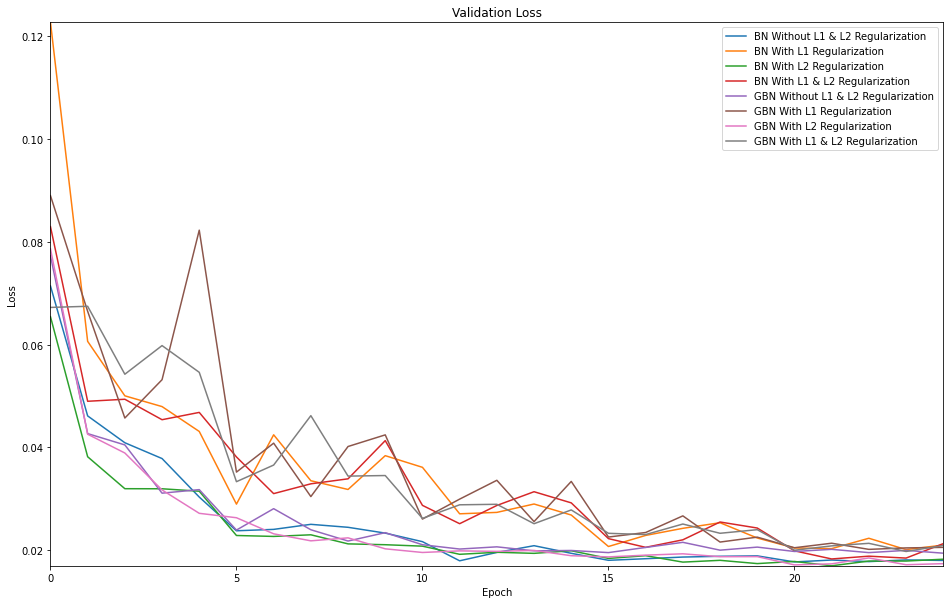

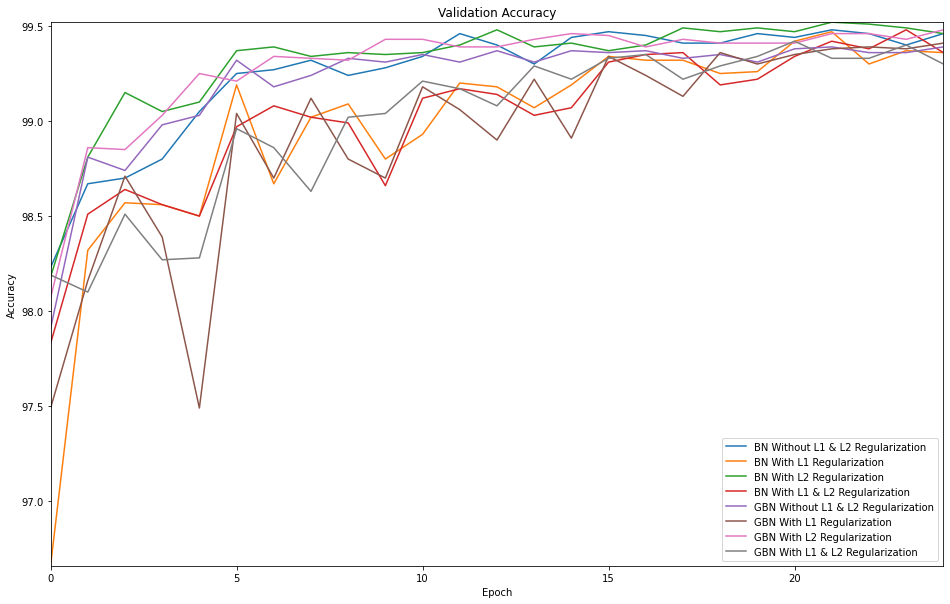

In [34]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(df_loss['BN Without L1 & L2 Regularization'],label='BN Without L1 & L2 Regularization')
ax.plot(df_loss['BN With L1 Regularization'],label='BN With L1 Regularization')
ax.plot(df_loss['BN With L2 Regularization'], label='BN With L2 Regularization')
ax.plot(df_loss['BN With L1 & L2 Regularization'], label='BN With L1 & L2 Regularization')
ax.plot(df_loss['GBN Without L1 & L2 Regularization'],label='GBN Without L1 & L2 Regularization')
ax.plot(df_loss['GBN With L1 Regularization'],label='GBN With L1 Regularization')
ax.plot(df_loss['GBN With L2 Regularization'], label='GBN With L2 Regularization')
ax.plot(df_loss['GBN With L1 & L2 Regularization'], label='GBN With L1 & L2 Regularization')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
leg = ax.legend();

from google.colab import files
plt.savefig("validation_loss.png")
files.download("validation_loss.png")

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(df_acc['BN Without L1 & L2 Regularization'],label='BN Without L1 & L2 Regularization')
ax.plot(df_acc['BN With L1 Regularization'],label='BN With L1 Regularization')
ax.plot(df_acc['BN With L2 Regularization'], label='BN With L2 Regularization')
ax.plot(df_acc['BN With L1 & L2 Regularization'], label='BN With L1 & L2 Regularization')
ax.plot(df_acc['GBN Without L1 & L2 Regularization'],label='GBN Without L1 & L2 Regularization')
ax.plot(df_acc['GBN With L1 Regularization'],label='GBN With L1 Regularization')
ax.plot(df_acc['GBN With L2 Regularization'], label='GBN With L2 Regularization')
ax.plot(df_acc['GBN With L1 & L2 Regularization'], label='GBN With L1 & L2 Regularization')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

from google.colab import files
plt.savefig("Validation_Accuracy.png")
files.download("Validation_Accuracy.png")

### Plot of Misclassified Images

In [28]:
misclassified_images_bn.shape, misclassified_target_bn.shape, misclassified_pred_bn.shape

(torch.Size([54, 28, 28]), torch.Size([54]), torch.Size([54]))

In [29]:
misclassified_images_gbn.shape, misclassified_target_gbn.shape, misclassified_pred_gbn.shape

(torch.Size([61, 28, 28]), torch.Size([61]), torch.Size([61]))

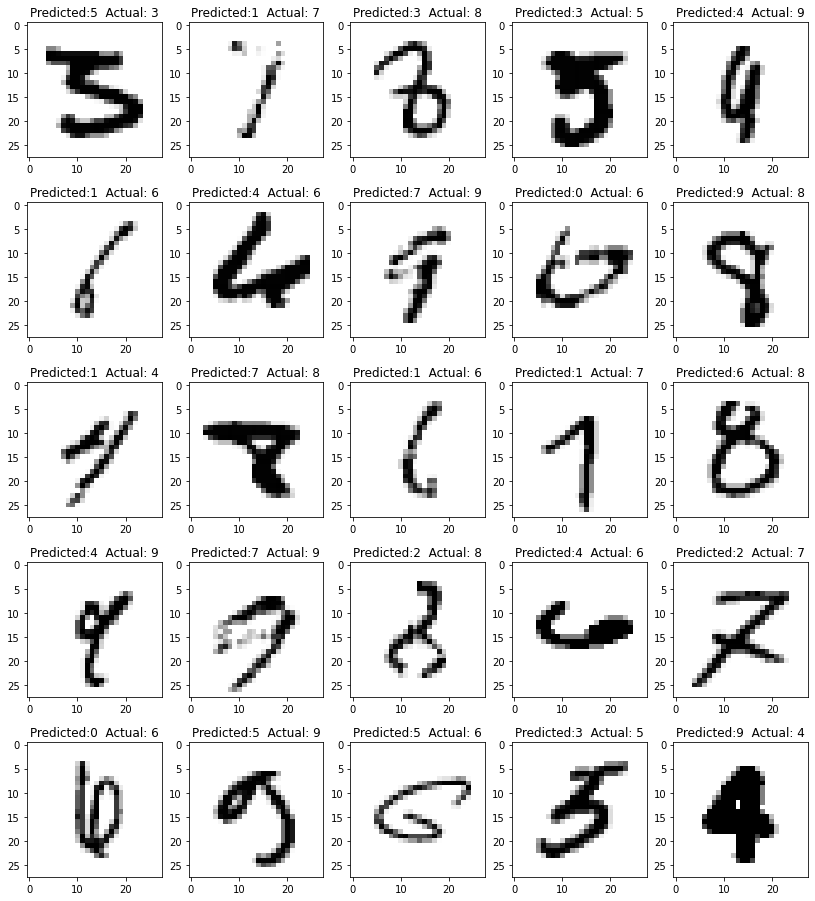

<Figure size 432x288 with 0 Axes>

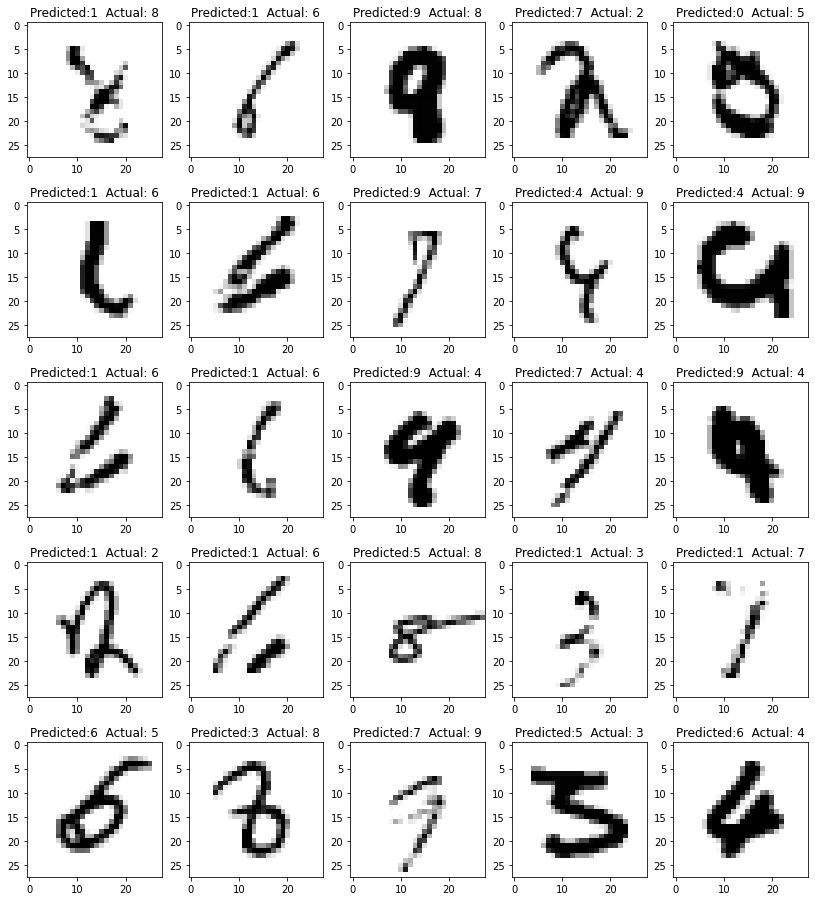

<Figure size 432x288 with 0 Axes>

In [30]:
fig=plt.figure(figsize=(14, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = misclassified_images_bn[i-1].to(torch.device("cpu"))
    pred = misclassified_pred_bn[i-1].to(torch.device("cpu"))
    tgt = misclassified_target_bn[i-1].to(torch.device("cpu"))
    #img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    #plt.imshow(img[:, :, 0].numpy().squeeze(),cmap='gray_r')
    plt.imshow(img.numpy().squeeze(),cmap='gray_r')
    plt.title("Predicted:"+str(pred)[7:8]+"  Actual: "+str(tgt)[7:8])
plt.show()
from google.colab import files
plt.savefig("Misclassified_Images_BN_WithoutL1L2.png")
files.download("Misclassified_Images_BN_WithoutL1L2.png")

fig=plt.figure(figsize=(14, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = misclassified_images_gbn[i-1].to(torch.device("cpu"))
    pred = misclassified_pred_gbn[i-1].to(torch.device("cpu"))
    tgt = misclassified_target_gbn[i-1].to(torch.device("cpu"))
    #img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    #plt.imshow(img[:, :, 0].numpy().squeeze(),cmap='gray_r')
    plt.imshow(img.numpy().squeeze(),cmap='gray_r')
    plt.title("Predicted:"+str(pred)[7:8]+"  Actual: "+str(tgt)[7:8])
plt.show()

from google.colab import files
plt.savefig("Misclassified_Images_GBN_WithoutL1L2.png")
files.download("Misclassified_Images_GBN_WithoutL1L2.png")